In [107]:
# Algemeen
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import sys
sys.path.insert(0, "..") 
from pprint import pprint

#Sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, roc_curve,classification_report

#Classificatie model
import tensorflow as tf 
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Regressie model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

<font size="10">Doorlooptijd facturen Moore DRV</font>

<font size="8">Project benadering</font>

Dit project is erop gericht om voor Moore DRV middels machine learning te kunnen voorspellen of een factuur binnen de betaal termijn van de factuur betaald wordt. Het project houdt in grote lijnen de structuur van de CRISP-DM methodiek aan welke is ontworpen voor Data Science vraagstukken. Hieronder is de CRISP-DM methodiek gevisualiseerd.

<img src=https://www.researchgate.net/profile/Vernon-Dsouza/publication/326235288/figure/fig1/AS:645518493495296@1530915010595/CRISP-DM-Model-Taylor-2017.png height="400">

<font size="8">1. Business understanding</font>

<font size="6">1.1 Context Moore DRV</font>

Moore DRV is een accountantskantoor met twaalf vestigingen verspreid in de regio Zuidwest-Nederland. Als accountantskantoor biedt het bedrijf een breed scala aan diensten voor haar klanten. Hierbij kan gedacht worden aan ondersteuning bij boekhoudkundige vragen, advies over fiscale zaken, het opmaken en/of het controleren van jaarrekeningen.

DRV is in veel opzichten een groeiende organisatie. Uit de jaarcijfers van 2019 blijkt dat de laatste vijf jaren niet alleen de omzet is toegenomen, maar ook het aantal FTE. De omzet bedroeg in 2019 bijna 60 miljoen, wat werd gerealiseerd door 600 medewerkers. Ter vergelijking: in 2015 was de omzet 40 miljoen en bedroeg het aantal medewerkers 358. De slogan van DRV luidt “Stilletjes een van de beste kantoren van Nederland”. Kwaliteit en clienttevredenheid zijn de kernwaarden van DRV en staan hoog in het vaandel. 

<font size="6">1.2 Bedrijfsdoel Moore DRV</font>

Met 12.000 particulieren en 12.000 zakelijke klanten bediend Moore DRV een groot aantal klanten. Deze klanten ontvangen op regelmatige basis facturen vanuit Moore DRV waarin het voltooide werk in rekening wordt gebracht. Op de Financiële afdeling van Moore DRV leeft het gevoel dat een aannemelijk deel van de facturen niet binnen de betaaltermijn betaald wordt. De doelstelling van Moore DRV voor dit project is dan ook om inzicht te krijgen in de factuurdata en om te kunnen voorspellen welke facturen wel of niet binnen de betaaltermijn kunnen worden betaald. 

De Data science doelstelling is uiteraard om zo nauwkeurig mogelijk te kunnen voorspellen of een factuur wel of niet op tijd betaald wordt binnen de betaal termijn. 

<font size="6">1.3 Aannames en beperkingen</font>

De opgehaalde klantdata is actueel terwijl de facturen enige historie bevat. Hierdoor zou het zo kunnen zijn dat de klant op het moment van facturen in een andere sector of klantgroep zat als er getoond word.  




<font size="10">2. Data Understanding</font>

<font size="6">2.1 Data verzameling</font>

Moore DRV heeft met betrekking tot het doel van dit project een dataset ter beschikking gesteld aan Geert Jansen, de student aan de Hogeschool Utrecht en tevens Data Analist bij DRV.
De dataset is afkomstig uit het datawarehouse van Moore DRV en is daar middels een SQL statement opgehaald. De data in het warehouse is afkomst uit Navision het ERP pakket van Moore DRV. 

In het SQL statement worden verschillende gegevens uit de facturatie tabel en de klant tabel opgehaald. De klant en facturatie worden gekoppeld door de een koppeling te maken op klantnummer. In het SQL statement worden al verschillend keuzes gemaakt om de data te selecteren, namelijk:
-	Er worden enkel facturen meegenomen vanaf 2019, deze keuze is gemaakt om geen gedateerde data mee te nemen en de dataset niet te groot te laten worden.
-	De factuur moet betaald zijn, wanneer dit niet het geval is kan er uiteraard niet worden bepaald of de factuur wel of niet op tijd betaald is.
-	Memoriaalboekingen en bankboekingen worden niet meegenomen de dataset, dit zijn administratieve boekingen en vervuilen daarmee de dataset.



<font size="6">2.2 Data beschrijving</font>

In onderstaande code wordt de data ingeladen welke is opgehaald is middels het SQL statement en in CSV formaat is opgeslagen. Voordat de data getoond wordt zullen de komen Welke Datums bevatten eerst in het juiste formaat worden gezet. Vervolgens worden de kolommen getoond deze zijn in te delen in 3 soorten.
1. Informatie kolommen, deze zullen niets toevoegen aan het model maar zijn wel belangrijk om inzicht in de data te krijgen in dit hoofdstuk. 
Factuurnummer, Payment Terms, Global Dimension 1 code, Global Dimension 2 code, Factuurdatum, Velrloopdatum, Sluitdatum, Betaaltermijn en DagenOpen
2. features, Dit zijn de kolommen welke als features zullen worden gebruikt om de voorspelling op te baseren.
Contact Type, Cusomer Posting Group, SBI Sector, Elec. factureren, GenormaliseerdBedrag en MaandFactuur
3. Target, Dit is de kolom OptijdBetaald en dit is de te voorspellen waarden.

Een aantal kolommen zijn niet duidelijk, deze zullen hieronder verder toegelicht worden:
- Contact Type > Deze kolom geeft aan of het een particulieren of zakelijke klant betreft.
- Customer Posting Group > Deze kolom geeft aan wat voor soort klant het betreft, dit zal vaak deb ofwel debiteur zijn.
- Global Dimension 1 Code > Aan welke bedrijf ofwel onderdeel van Moore DRV is de klant gekoppeld.
- Global Dimension 2 code > Aan welke vestiging van het bedrijf van DRV is de klant gekoppeld.
- SBI Sector > SBI staat voor Standaard Bedrijfsindeling en is er voor gemaakt om bedrijven te kunnen verdelen in verschillende sectoren.
- Elec. factrureren > Dit geeft aan of de klant wel of niet elektronisch de facturen wil ontvangen, dit kan van invloed zijn op de betaal termijn.
- GenormalisseerdBerdag > Deze kolom geeft de hoogte van het factuur bedrag aan, deze waarde is al genormaliseerd in de brondata.

Wat direct opvalt is de grote van de dataset, met rond de 116 rijen is behoorlijk te noemen. Wat ook opvalt zijn de kolommen SBI en Maand, deze kolommen zullen moeten worden omgezet als deze worden gebruikt in het modeleren omdat deze geen gerangschikte waarde bevatten.

In [108]:
# Data ophalen in data file
datafolder = Path("../data/raw")
data = pd.read_csv(datafolder / "Data csv - 17-1-2022.csv")

# Datums omzetten naar juiste formaat
data['Factuurdatum'] = pd.TimedeltaIndex(data['Factuurdatum'], unit='d') + dt.datetime(1899,12,30) 
data['Verloopdatum'] = pd.TimedeltaIndex(data['Verloopdatum'], unit='d')+ dt.datetime(1899,12,30) 
data['Sluitdatum'] = pd.TimedeltaIndex(data['Sluitdatum'], unit='d') + dt.datetime(1899,12,30) 

In [109]:
# Data tonen 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116131 entries, 0 to 116130
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Factuurnummer            116131 non-null  object        
 1   Global Dimension 2 Code  116131 non-null  object        
 2   Contact Type             116131 non-null  int64         
 3   Payment Terms Code       116131 non-null  object        
 4   Customer Posting Group   116131 non-null  object        
 5   Global Dimension 1 Code  116131 non-null  object        
 6   Factuurdatum             116131 non-null  datetime64[ns]
 7   SBI Sector               104803 non-null  float64       
 8   elec. factureren         116131 non-null  int64         
 9   Maand                    116131 non-null  int64         
 10  GenormalisserdBedrag     116131 non-null  float64       
 11  Verloopdatum             116131 non-null  datetime64[ns]
 12  Sluitdatum      

In [110]:
# Bovenste 5 rijen laten zien.
data.head(5)

,Factuurnummer,Global Dimension 2 Code,Contact Type,Payment Terms Code,Customer Posting Group,Global Dimension 1 Code,Factuurdatum,SBI Sector,elec. factureren,Maand,GenormalisserdBedrag,Verloopdatum,Sluitdatum,Betaaltermijn,DagenOpen,OptijdBetaald
0,AA21-005812,AABZ,0,14 DAGEN,DEB,AA,2021-02-04,94.0,0,2,-0.321646,2021-02-18,2021-03-04,14,28,0
1,AA21-010236,AAGO,0,14 DAGEN,DEB,AA,2021-03-01,64.0,1,3,-0.321646,2021-03-15,2021-04-19,14,49,0
2,AA20-004861,AAMB,0,14 DAGEN,DEB,AA,2020-01-31,47.0,0,1,-0.321646,2020-02-14,2020-03-11,14,40,0
3,AA20-012411,AAGO,0,14 DAGEN,DEB,AA,2020-03-24,70.0,1,3,-0.321176,2020-04-07,2020-04-14,14,21,0
4,AA21-038194,AAOB,0,14 DAGEN,DEB,AA,2021-09-23,41.0,0,9,-0.321176,2021-10-07,2021-10-06,14,13,1


<font size="6">2.3 Data verkenning</font>

In onderstaande paraaf zullen per kolom gegevens worden verkend met alvast een kleine vooruitblik op het verband met de te voorspellen target.

<font size="5">2.3.1 Verkenning per soort</font>

- Verloop aantal facturen

Het verloop van het aantal facturen heeft een bepaald seizoen verloop. Uit onderstaande illustraties is te halen dat er met name in zomermaanden augustus en september minder wordt facturen worden verstuurd dan in de overige maanden. Het aantal facturen lijkt in voor de geselecteerde periode geen grote toenamen of afnamen te vertonen. Daarnaast kan worden gezien dat er op de 1ste van de maand en vanaf halverwege de maand de meeste facturen verstuurd worden, dit heeft geen verdere invloed op het model maar is wel goed om te weten. 

<AxesSubplot:xlabel='Maand', ylabel='Aantal facturen'>

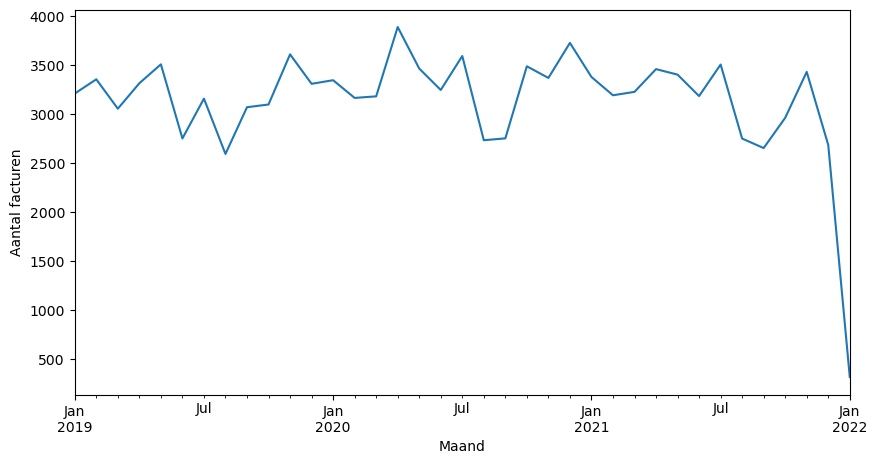

In [111]:
# Verdeel het aantal facturen per jaar-maand
data['month_year'] = pd.to_datetime(data['Factuurdatum']).dt.to_period('M')
# Plot lijngrafiek
MothCount = data.groupby('month_year')["Factuurnummer"].count()
MothCount.plot(kind = 'line',ylabel='Aantal facturen', xlabel='Maand', figsize=(10, 5))

<AxesSubplot:xlabel='Dag', ylabel='Aantal facturen'>

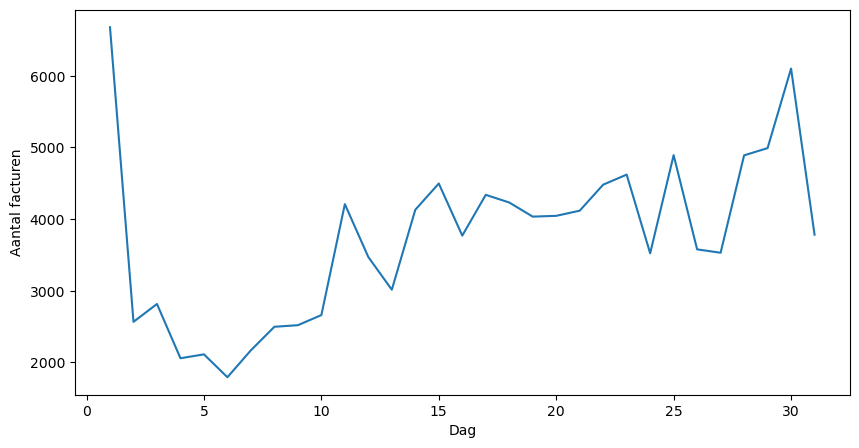

In [112]:
# Verdeel het aantal facturen per dag
data['Factuur_Day'] = data['Factuurdatum'].dt.day
# Plot lijngrafiek
DayCount = data.groupby('Factuur_Day')["Factuurnummer"].count()
DayCount.plot(kind = 'line',ylabel='Aantal facturen', xlabel='Dag', figsize=(10, 5))

Vestingen
- Aantal per vesting.

In onderstaande illustratie het aantal facturen per vestiging te zien verdeelt in wel of niet op tijd betaald. Ondanks dat er verschil zit tussen de vestigingen en de verdeling wel/niet op tijd betaald zal dit veld niet als veld mee worden genomen als features.


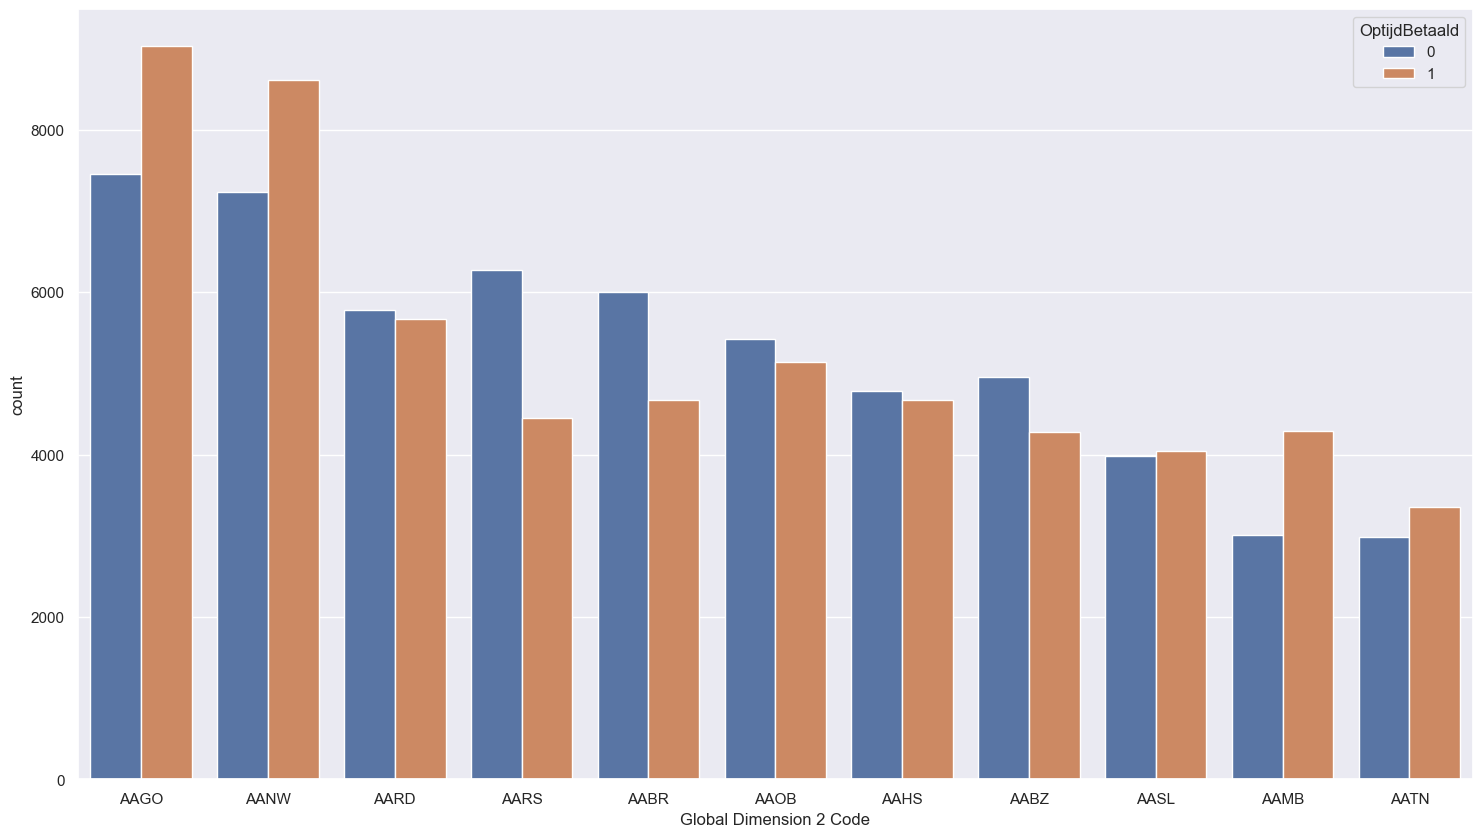

In [113]:
# Plot het aantal facuren per vestiging per betaal catagorie.
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="Global Dimension 2 Code",hue = "OptijdBetaald", data=data,order=data['Global Dimension 2 Code'].value_counts().index)

- Betaal gedrag

Het aantal wel of niet op tijd betaalde facturen is ongeveer gelijk, dit is mooi startpunt voor ons model. Daarnaast is te zien dat het grootste deel van de op tijd betaalde facturen op dag 13 of 14 wordt betaald. Wanneer de naar de spreiding word van het aantal dagen wordt gekeken middels een boxplot valt op dat er veel outliers zijn, dit kan de prestaties van het regressie model beïnvloeden. Net als voor vestiging verschild verhouding wel of niet op tijd betaald per maand, dit maakt dat dit ook een interessante parameter kan zijn.

Wanneer de gemiddelde van de overige parameters voor zowel de groep facturen die op tijd zijn betaald als voor de groep welke dat niet kan worden geconcludeerd dat:

- Zakelijke Klanten vaker op tijd betalen.
- Klanten met elektronisch factureren niet altijd sneller betalen als klant zonder elektronisch factureren. 
- Hoe lager het factuur bedrag, hoe groter de kans dat de factuur op tijd betaald wordt. 


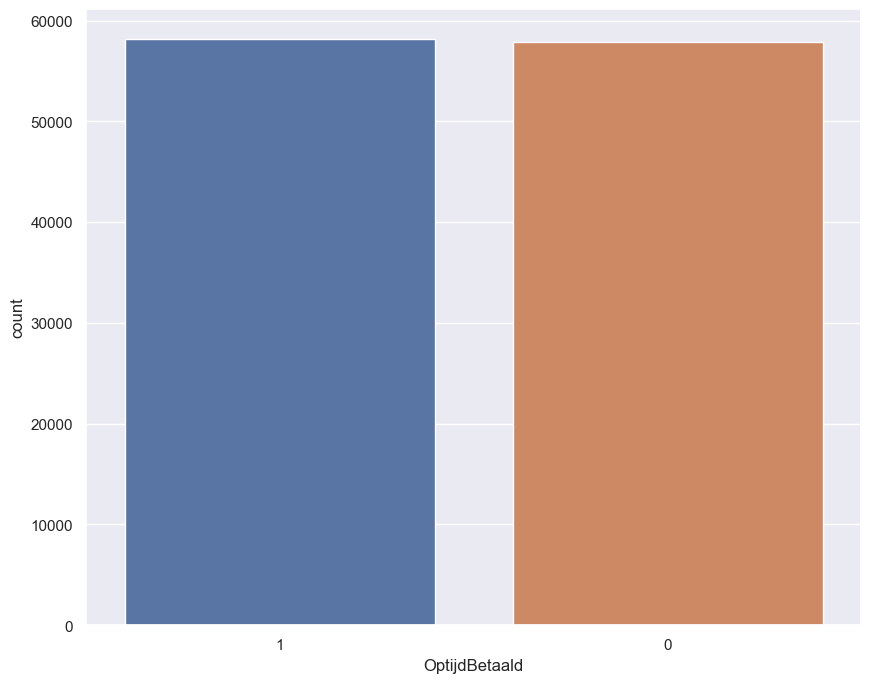

In [114]:
# Plot het aantal facuren per betaal catagorie.
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x="OptijdBetaald", data=data,order=data['OptijdBetaald'].value_counts().index)

<AxesSubplot:xlabel='Dagen open', ylabel='Aantal facturen'>

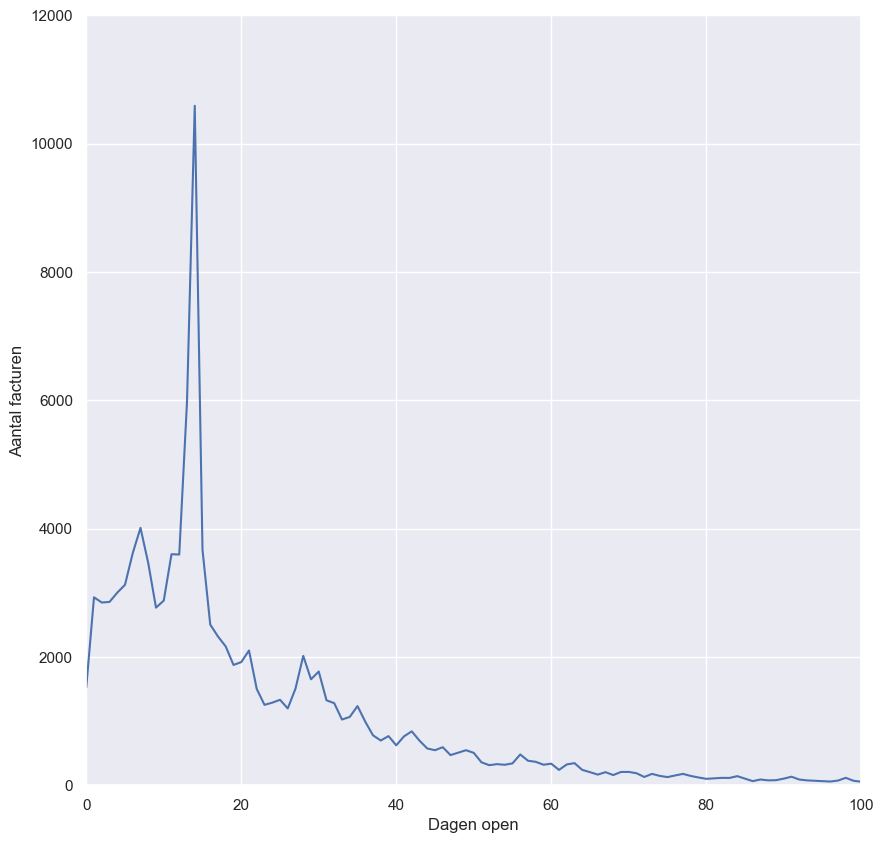

In [115]:
# Plot het aantal facuren per betaal dag
MothCount = data.groupby('DagenOpen')["Factuurnummer"].count()
MothCount.plot(kind = 'line',ylabel='Aantal facturen', xlabel='Dagen open', figsize=(10, 10),xlim=(0,100),ylim=(0,12000))

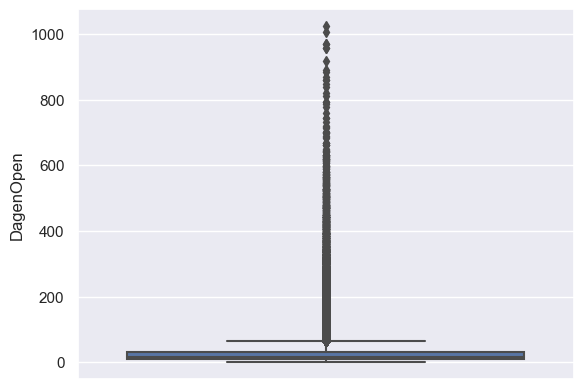

In [116]:
# Plot de verdeling van het aantal dagen open in een boxplot

sns.boxplot( y=data[ "DagenOpen" ]); 
plt.show()

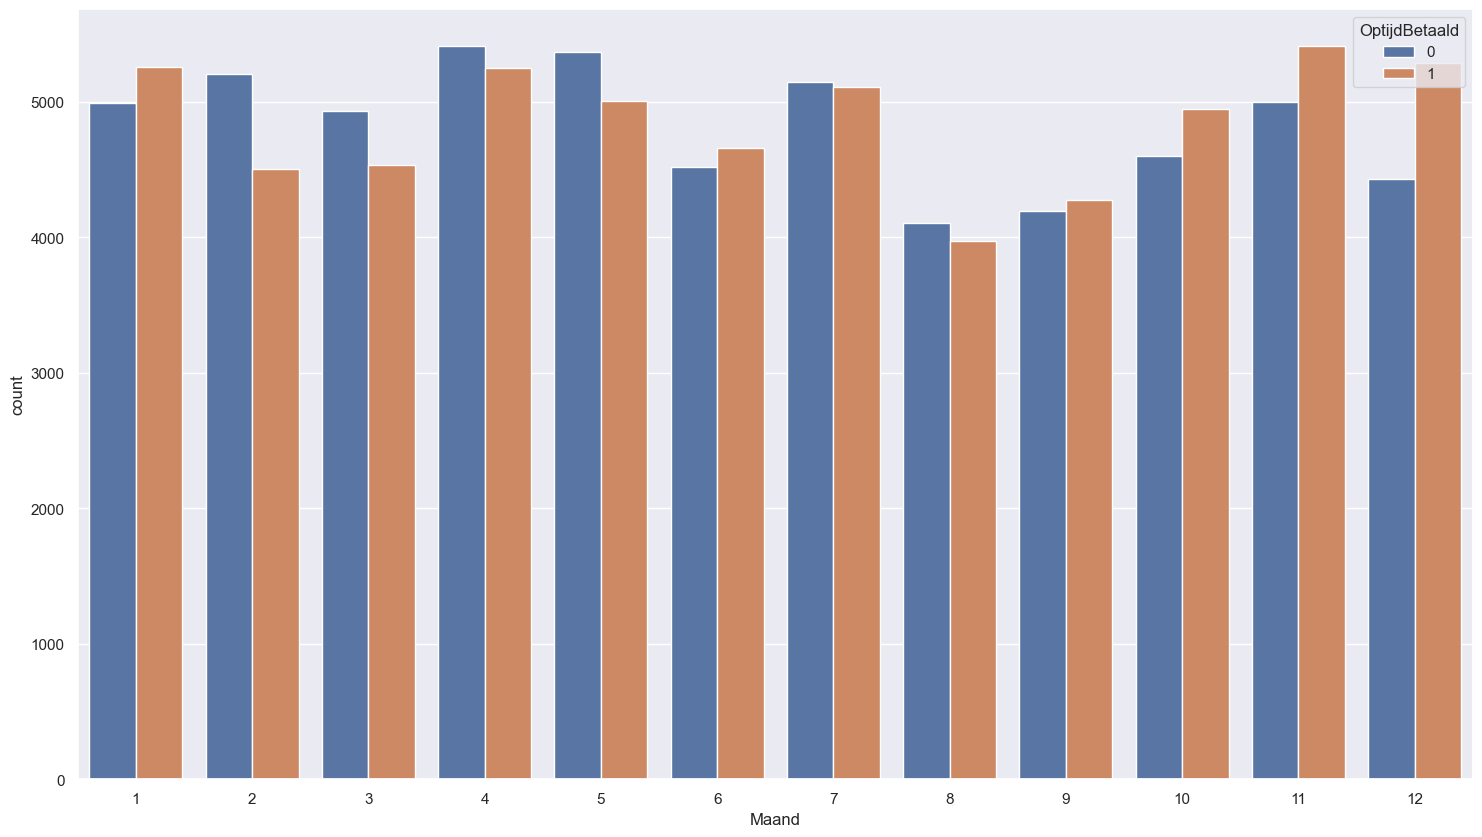

In [117]:
# Plot het aantal facuren per maand per betaal catagorie.
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="Maand",hue = "OptijdBetaald", data=data)

In [118]:
# Gemiddeldes per betaal catagorie.
data.groupby('OptijdBetaald').mean()

,Contact Type,SBI Sector,elec. factureren,Maand,GenormalisserdBedrag,Betaaltermijn,DagenOpen,Factuur_Day
OptijdBetaald,,,,,,,,
0,0.062269,55.661556,0.681989,6.330513,-0.133035,14.580262,46.824434,17.348195
1,0.112880,57.076953,0.597654,6.533605,-0.148364,14.874238,9.241889,17.493362


SBI Code

Het aantal facturen per SBI code loopt flink uiteen, om een beeld te vormen hieronder de drie sectoren waarna de meeste facturen worden verstuurd. Ook voor deze parameter lijkt verschil te zitten in de verdelingen tussen wel en niet betaalde facturen, waardoor ook deze features interessant kan zijn. Helaas moet ook geconcludeerd worden dat er veel SBI-Codes te vinden zijn, dit kan de prestaties van het model negatief beïnvloeden. 

1. 64 > Financiële instellingen (geen verzekeringen en pensioenfondsen)
2. 46 > Groothandel en handelsbemiddeling (niet in auto’s en motorfietsen)
3. 47 > Detailhandel (niet in auto’s)

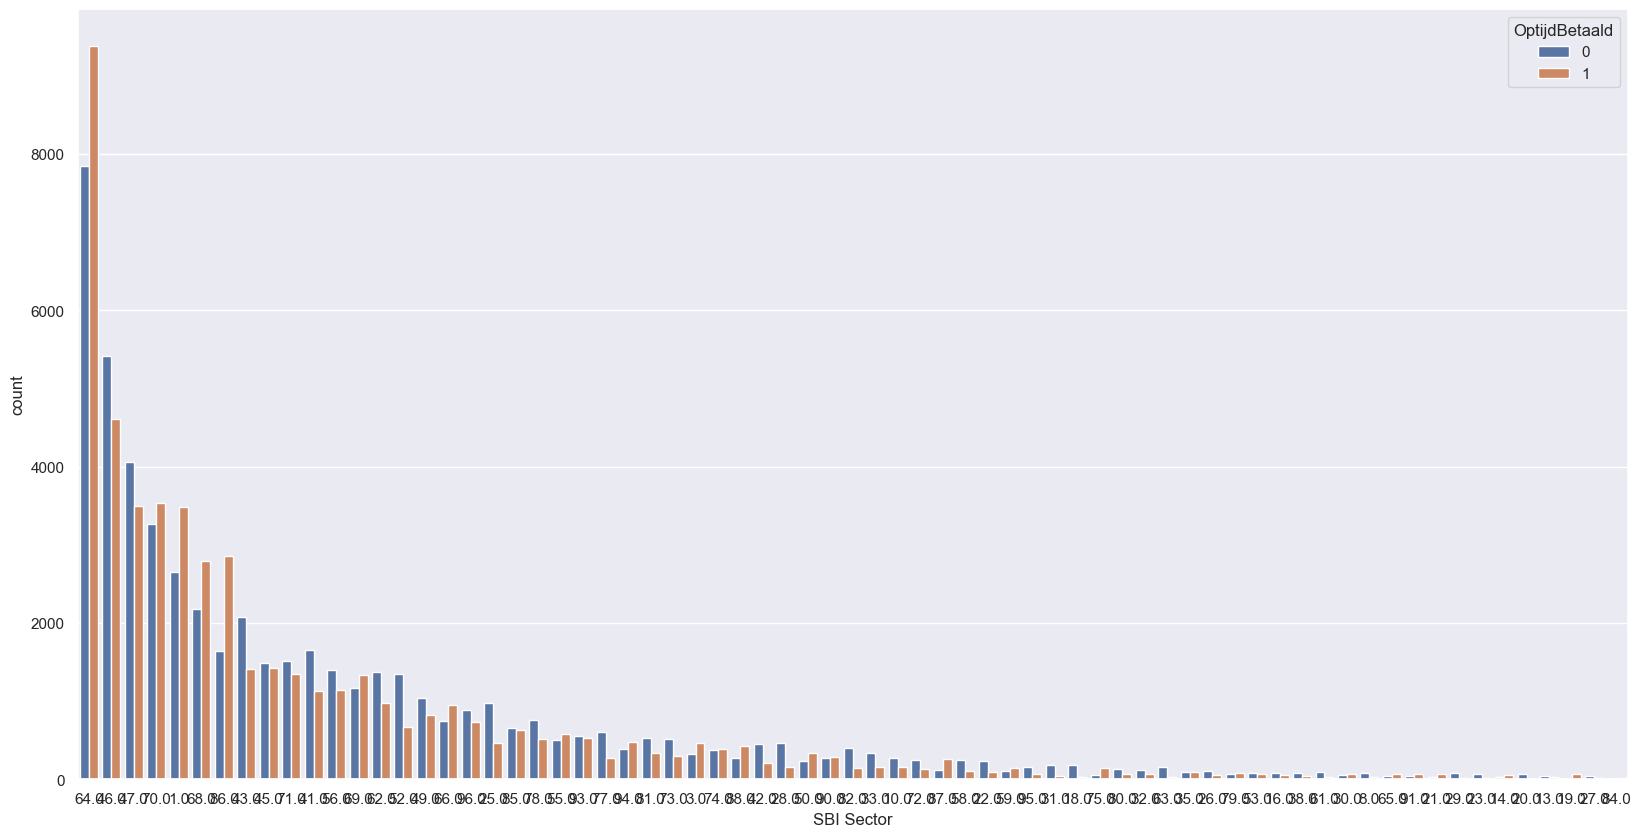

In [119]:
# Aantal facturen per sector per betaal catagorie.
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x="SBI Sector",hue = "OptijdBetaald", data=data,order=data['SBI Sector'].value_counts().index)

- Contact type

Er is een aanzienlijk verschil tussen het aantal facturen per contact type er zijn meer facturen naar 0(zakelijke) dan naar 1(particulieren) klanten gestuurd. Ook de verdeling tussen de het wel of niet op tijd betalen en de type klant lijkt niet gelijk, zakelijke klanten betalen vaker niet op tijd dan wel op tijd voor particulieren is dit precies andersom. 

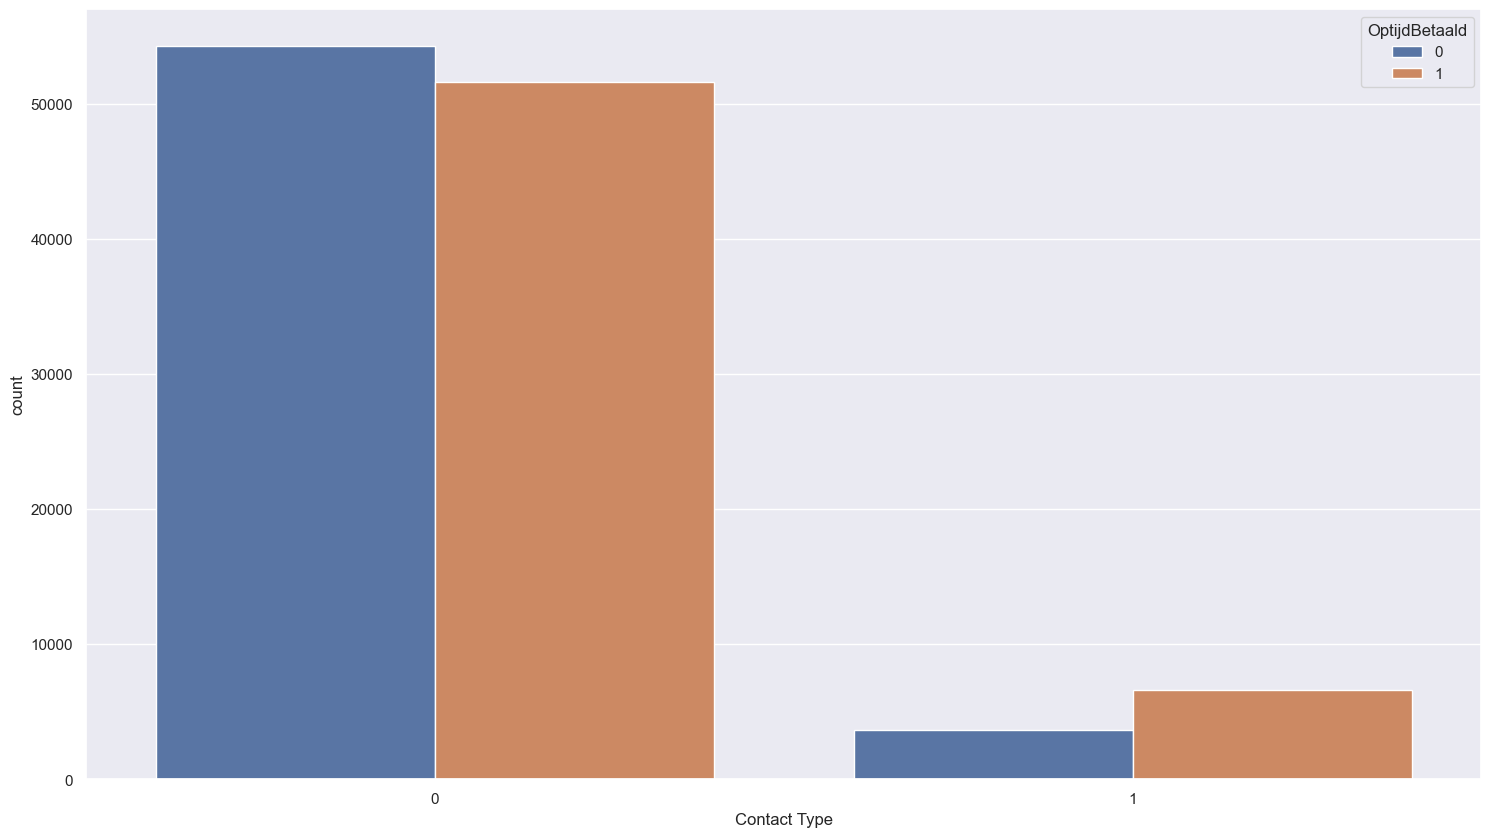

In [120]:
# Aantal facturen per contact type per betaal catagorie.
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="Contact Type",hue = "OptijdBetaald", data=data,order=data['Contact Type'].value_counts().index)

- Contact factuurtype

Er worden meer facturen gestuurd naar klanten met elektronisch facturen als klant zonder deze instelling. Ook voor deze feature geld dat de verdeling van elkaar afwijken. De klanten zonder elektronisch factureren betalen vaker op tijd dan niet op tijd, voor de klanten met elektronisch factureren is dit precies andersom.

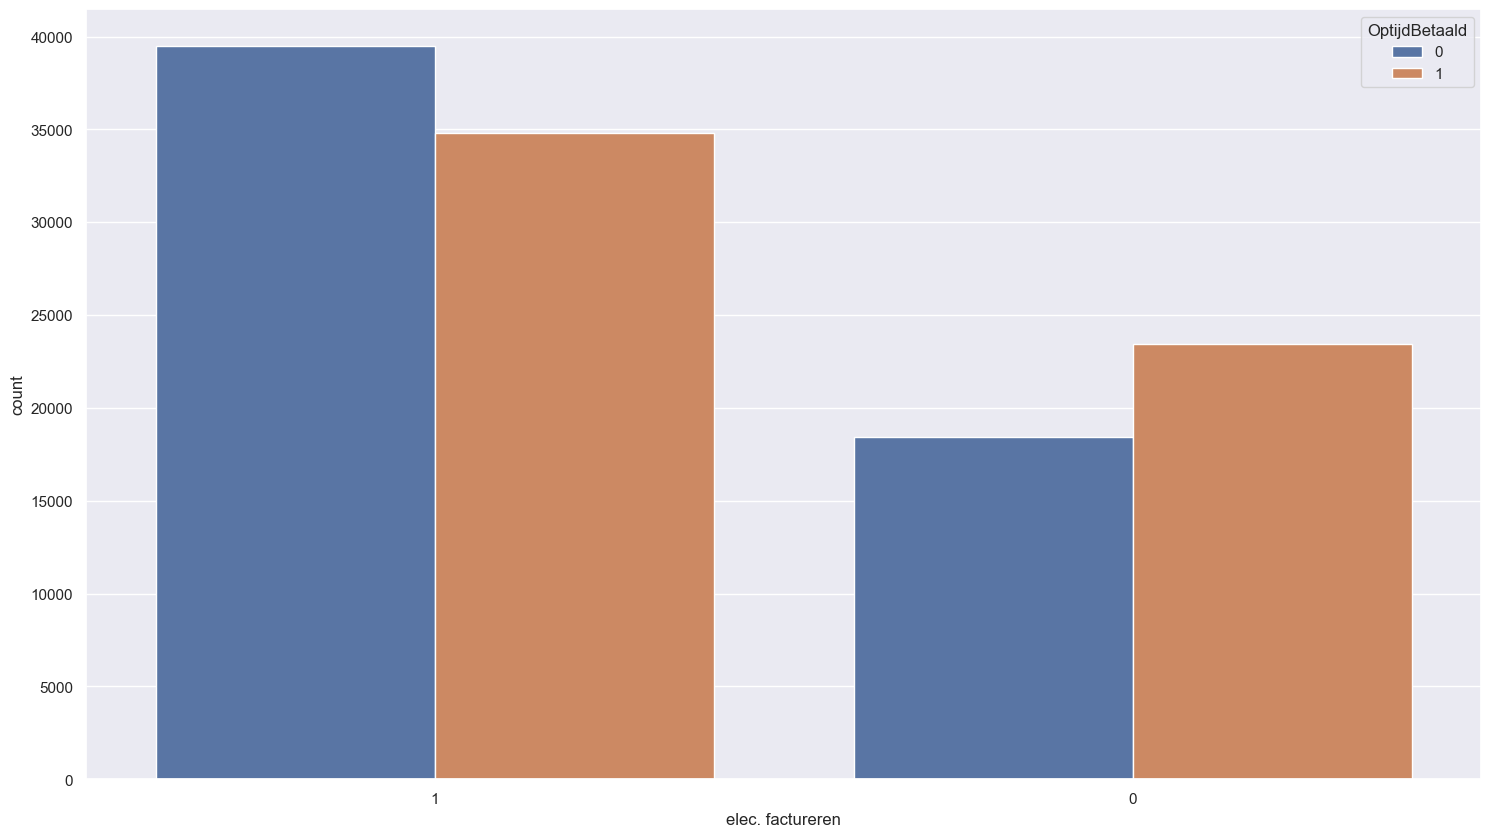

In [121]:
# Aantal facturen per factuurtype per betaal catagorie.
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.countplot(x="elec. factureren",hue = "OptijdBetaald", data=data,order=data['elec. factureren'].value_counts().index)

- Factuurbedrag

Zoals eerder vermeld zijn de bedragen genormaliseerd zodat deze niet te herleiden zijn de echte bedragen. Toch kan er op basis van onderstaande boxplot worden gezegd dat er enige spreiding is in de grootte van het factuurbedrag en er zeker aan de bovenkant een aantal uitschieters in factuurbedragen te vinden zijn. 

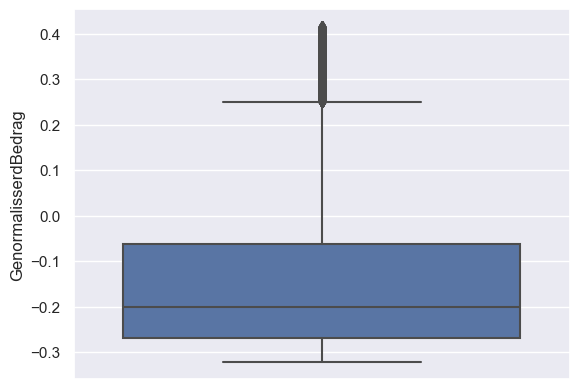

In [122]:
# Spreiding genormaliseerde bedragen 
sns.boxplot( y=data[ "GenormalisserdBedrag" ]); 
plt.show()

<font size="6">2.4 Data kwaliteit</font>

- Onbekende waarden

In onderstaande illustratie is te zien dat er een waarde is waarde is waar relatief veel missende waardes zijn namelijk SBI-code. De reden hiervan is goed te verklaren, een particulier is namelijk niet in te delen in een sector omdat het geen bedrijf betreft. Er zal dus goed gekeken moeten worden welke invloed dit heeft op het model.

<AxesSubplot:xlabel='Kolommen', ylabel='Aaantal NA'>

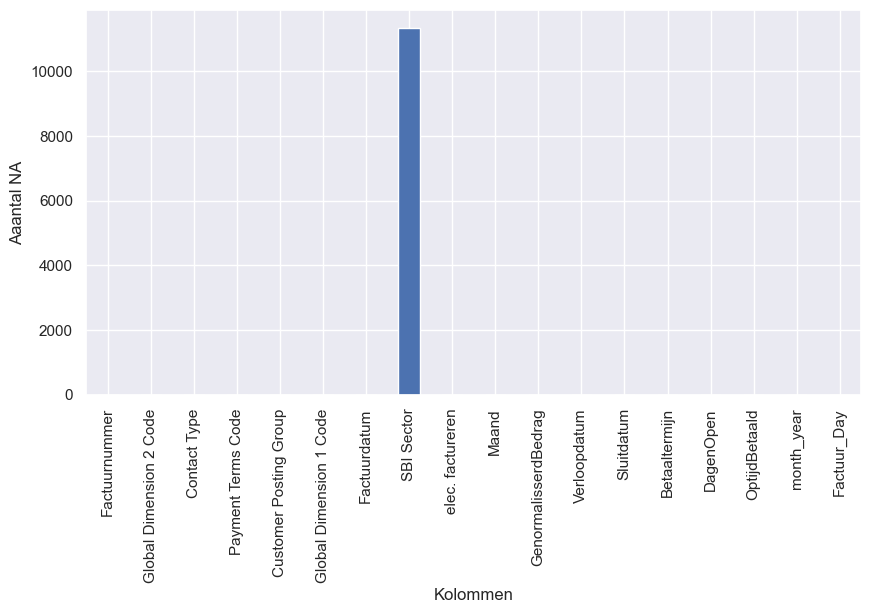

In [123]:
# Aantal nul waarde per colom. 
ISna = data.isna().sum() 
ISna.plot(kind = 'bar',ylabel='Aaantal NA', xlabel='Kolommen', figsize=(10, 5))

<font size="6">2.5 Conclusies data verkenning</font>

De verkenning heeft een aantal interessante inzichten opgeleverd welke meegenomen kunnen worden naar de modeleer fases.
1. Er zijn een aantal interessante features waar het wel of niet op tijd betalen per feature lijkt af te wijken, dit is bijvoorbeeld het geval bij elec. factureren, Contact Type, SBI Sector em factuurmaand.

2. De spreiding in het aantal dagen dat een factuur open staat is erg groot er zitten veel outliers in waar de factuur lang open staat.

3. Er zijn veel SBI-codes te vinden in de dataset, dit kan de performance van het model gaan beïnvloeden doordat het aantal kolommen(features) hier van zal gaan groeien.

4. De datakwaliteit lijkt wel in orde te zijn, er kan geen SBI-code worden gevonden voor facturen welke naar particulieren klanten zijn gestuurd, dit is echter nog geen 10% van de facturen. 

<font size="10">3 Data prepareren</font>


<font size="6">3.1 Data selecteren</font>

In onderstaande fase worden alle kolommen welke niet noodzakelijk zijn voor het model verwijderd, zo blijven er alleen features en de target over. 

In [124]:
# Verwijder onnodige kolommen
data = data.drop(['Factuurnummer','Global Dimension 2 Code', 'Payment Terms Code','Customer Posting Group','Global Dimension 1 Code','Factuurdatum',
'Verloopdatum','Sluitdatum','Betaaltermijn','DagenOpen','month_year','Factuur_Day'], axis = 1)

# Definieer target
data = data.rename(columns={'OptijdBetaald': 'target'})

# toon top 5 overgebleven data.
data.head(5)

,Contact Type,SBI Sector,elec. factureren,Maand,GenormalisserdBedrag,target
0,0,94.0,0,2,-0.321646,0
1,0,64.0,1,3,-0.321646,0
2,0,47.0,0,1,-0.321646,0
3,0,70.0,1,3,-0.321176,0
4,0,41.0,0,9,-0.321176,1


<font size="6">3.2 Train en test split</font>

De data wordt in onderstaande fase gesplitst in een train en een test set. Zoals in voorgaande hoofdstuk al duidelijk is geworden bevat de data set 116.478 rijen. Door de grote van deze dataset is er behoorlijk wat flexibiltiet om de grote van de train en de test bepalen. Er is voor gekozen om de train test verdeling van 80/20 aan te houden op basis van onderstaande bron.

Er gekozen om de verdeling door de train_test_split module van Sklearn te leten doen, deze split de dataset random waardoor er minder kans is op voorkeuren in de data.
naar particulieren klanten zijn gestuurd, dit is echter nog geen 10% van de facturen. 

<img src=https://www.baeldung.com/wp-content/uploads/sites/4/2021/01/split_dataset-n-on-split.png height="400">

(A. Aylin Tokuç,2021)

In [125]:
# Split data in X en y. 
X = data.drop('target', axis=1)
y = data['target']

# Verdeel data in train en test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

# Toon de nieuwe verdeling per data set
data.shape , X_train.shape, X_test.shape,y_train.shape,y_test.shape

((116131, 6), (92904, 5), (23227, 5), (92904,), (23227,))

<font size="6">3.3 Data prepareren</font>

In onderstaande fase wordt de datasets gereed gemaakt om op te trainen en testen. De kolommen SBI Sector en Maand bevatten categorische kenmerken welke geen specifieke voorkeursvolgorde hebben daardoor kan het model niet omgaan met deze waarden. De oplossing welke is gekozen is one hot encoding, hierdoor worden deze kolommen verdeeld over het aantal unieke waarde welke in deze kolom zit. Hierdoor neemt het aantal features toe van 5 naar 84, dit kan een nadeel zijn voor de werking van het model.

Als laatste worden de datasets omgezet naar NuMPy-arrays, deze zijn sneller, compacter en makkelijker te optimaliseren. 

In [55]:
# One-hot ecoding op maand en SBI per dataset
X_train = pd.get_dummies(X_train, columns = ['Maand','SBI Sector'])
X_test = pd.get_dummies(X_test, columns = ['Maand','SBI Sector'])

# Zet data in numpy frame
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Toon de nieuwe verdeling per data set
data.shape , X_train.shape, X_test.shape,y_train.shape,y_test.shape

((116131, 6), (92904, 84), (23227, 84), (92904,), (23227,))

<font size="10">4 Modeleren</font>

In deze fase zal middels machine learning modellen worden geprobeerd zo nauwkeurig mogelijk te voorspellen of een factuur op tijd betaald. Daarnaast zal een poging worden gedaan om te voorspellen hoelang een factuur open zal staan.

Classificatie

Middels classificatie zal o.b.v. bepaalde features worden bepaald of zich in de klasse wel op tijd bepaald of niet optijd betaald bevind. Er is gekozen voor een neuraal netwerk middels een keras Sequetail model met als output een binaire klasse(wel of niet op tijd betaald). Er is voor dit neurale netwerk gekozen omdat het makkelijk is in gebruik en goed te combineren met de Keras tuner welke in tegenstelling tot Ray wel goed werkt op een windows laptop. 

In onderstaande illustratie is een voorbeeld van een Keras neuraal netwerk te zien. De input is in dit geval de 84 features uit hoofdstuk 3, de output is 0 of 1 wel of niet op tijd betaald. In paragraaf 4.1 en 4.2 zal worden onderzocht hoeveel lagen er toegevoegd moeten worden en hoe groot deze lagen moeten zijn.

<img src=https://miro.medium.com/max/1400/0*IlHu39jf2c7QC4kn. height="200">

<font size="6">4.1 baseline</font>

Hieronder is een baseline model gecreëerd, een baseline model dient als een benchmark van de mogelijkheden op de dataset. Voor het baseline model is gekozen voor een simpel Sequential model van Keras met 1 Dense layer. Wanneer er gekeken wordt naar de performance van dit model kan worden geconcludeerd dat deze matig zijn. Zoals in hoofdstuk is te zien is der verdeling per klasse ongeveer 50%,  dit model geeft een nauwkeurigheid van 56 % wat een verbetering is ten opzichten van een gok maar het niet veel beter.

In [56]:
# Bouw baseline model met Keras
model = Sequential()
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'])
historyBase = model.fit(X_train, y_train,validation_data=(X_test, y_test))

2904/2904 [==============================] - 4s 1ms/step - loss: 0.6794 - accuracy: 0.5662 - val_loss: 0.6743 - val_accuracy: 0.5814


<font size="6">4.2 Model Keras</font>

In onderstaande code wordt een model gebouwd Op dezelfde manier als het basseline model als hierboven echter wordt dit model uitgebreider. Daarnaast wordt er middel de Kerastuner geprobeerd de beste parameters te vinden om het model zo goed mogelijk te laten presteren. Hieronder de verschillende parameters uitgelegd:

- Aantal lagen > Uit hoeveel lagen het model bestaat kan van invloed zijn op de prestaties van het model. Door te testen is gebleken dat 4 lagen de hoogste nauwkeurigheid oplevert.

- Units per laag > Het aantal units per laag wordt in onderstaande model beslist door de tuner en kan per laag verschillen tussen 8,16,32 of 64.

- Activation > Welke activatie wordt gekozen per unit, in machine learining wordt vaak de Rulu gebruikt maar het kan interessant zijn ook eens de kijken hoe het model reageert op de tahn.

- Learning rate > Deze parameter bepaald hoeveel het model wordt gewijzigd als de gewichten worden bijgewerkt. Een te lage waarde kan leiden tot slechter leer prestaties terwijl een te hoge waarde kan leiden tot een onstabiel proces.

Met de juiste waardes kan zoals verwacht een beter prestatie worden behaald dan in het baseline model echter blijkt dat de nauwkeurigheid slechts een paar procent is toegenomen.

In [66]:
# Bouw uitgebereid model met Keras
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32,64,128]),
      hp.Choice("activation", ["sigmoid","relu","tanh"]),
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
      hp.Choice("kernel_initializer",['he_uniform','normal'])))
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32,64,128]),
      hp.Choice("activation", ["sigmoid","relu", "tanh"]),
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
      hp.Choice("kernel_initializer",['he_uniform','normal'])))
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32,64,128]),
      hp.Choice("activation", ["sigmoid","relu", "tanh"]),
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
      hp.Choice("kernel_initializer",['he_uniform','normal'])))
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32,64,128]),
      hp.Choice("activation", ["sigmoid","relu", "tanh"]),
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]),
      hp.Choice("kernel_initializer",['he_uniform','normal'])))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='binary_crossentropy',  optimizer='adam', metrics=['accuracy'])

  return model

  build_model(kt.HyperParameters())

In [67]:
# Definieer de te hypertunen parameters
tuner = kt.RandomSearch(
    hypermodel= build_model,
    objective="accuracy",
    max_trials=1,
    executions_per_trial=1,
    overwrite=True,
    directory="my_dir",
)

In [68]:
# Vindt de beste parameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Trial 1 Complete [00h 08m 36s]
accuracy: 0.5928915739059448

Best accuracy So Far: 0.5928915739059448
Total elapsed time: 00h 08m 36s
INFO:tensorflow:Oracle triggered exit


In [69]:
# Toon de samenvatting van de beste parameters
tuner.results_summary()

Results summary
Results in my_dir\untitled_project
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
units: 8
activation: tanh
learning_rate: 0.0001
kernel_initializer: he_uniform
Score: 0.5928915739059448


In [70]:
# Geef de twee beste parameters
best_hps = tuner.get_best_hyperparameters(2)
# Bouw het model met de beste parameters
model = build_model(best_hps[0])
# Fit het model met de verschillende datasets
x_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

historyXY = model.fit(X_train, y_train,epochs=100,validation_data=(X_test, y_test))
historyALL = model.fit(x=x_all, y=y_all, epochs=200)

# Maak een lijst aan met de voorspelde waarde
y_pred = model.predict(x_all)

Epoch 1/100
2904/2904 [==============================] - 6s 2ms/step - loss: 0.7384 - accuracy: 0.5622 - val_loss: 0.6758 - val_accuracy: 0.5751
Epoch 2/100
2904/2904 [==============================] - 8s 3ms/step - loss: 0.6749 - accuracy: 0.5758 - val_loss: 0.6735 - val_accuracy: 0.5782
Epoch 3/100
2904/2904 [==============================] - 5s 2ms/step - loss: 0.6741 - accuracy: 0.5788 - val_loss: 0.6733 - val_accuracy: 0.5784
Epoch 4/100
2904/2904 [==============================] - 4s 1ms/step - loss: 0.6729 - accuracy: 0.5791 - val_loss: 0.6753 - val_accuracy: 0.5768
Epoch 5/100
2904/2904 [==============================] - 4s 1ms/step - loss: 0.6728 - accuracy: 0.5819 - val_loss: 0.6708 - val_accuracy: 0.5856
Epoch 6/100
2904/2904 [==============================] - 4s 1ms/step - loss: 0.6722 - accuracy: 0.5810 - val_loss: 0.6708 - val_accuracy: 0.5841
Epoch 7/100
2904/2904 [==============================] - 4s 1ms/step - loss: 0.6716 - accuracy: 0.5813 - val_loss: 0.6720 - val_ac

<font size="6">4.3 Model regressie</font> 

In deze paragraaf zal worden onderzocht worden of er modellen zijn waar middels regresie het aantal openstaande dagen van een factuur voorspeld kan worden. Dit zal gebeuren middels een random-forest model, dit model kan gebruikt worden voor zowel classificatie als regressie problemen en kan goed omgaan met grote dataset zoals in dit geval. 

Zoals hieronder is te zien worden de features in dit model door verschillende beslisbomen gehaald om te samen tot een gemiddeld getal te komen. 

<img src=https://miro.medium.com/max/1400/0*f_qQPFpdofWGLQqc.png height="300">

<font size="5">4.3.1 Data preparatie</font>

Voor het regressie model zal er tussentijds een data preparatie plaats moeten vinden, dit doordat de target veranderd van wel of niet betaald naar het aantal openstaande dagen.

In [22]:
# Haal de data opnieuw op
dataRegressie = pd.read_csv(datafolder / "Data csv - 17-1-2022.csv")

# Verwijder onnodige kolommen
dataRegressie = dataRegressie.drop(['Factuurnummer','Global Dimension 2 Code', 'Payment Terms Code','Customer Posting Group','Global Dimension 1 Code','Factuurdatum',
'Verloopdatum','Sluitdatum','Betaaltermijn','OptijdBetaald'], axis = 1)

# Definieer target
dataRegressie  = dataRegressie .rename(columns={'DagenOpen': 'target'})

In [23]:
# Split data in X en y. 
X = dataRegressie.drop('target', axis=1)
y = dataRegressie['target']

# Verdeel data in train en test dataset.
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X, y, train_size = 0.8)

# Toon de nieuwe verdeling per data set
dataRegressie.shape , X_trainR.shape, X_testR.shape,y_trainR.shape,y_testR.shape

((116131, 6), (92904, 5), (23227, 5), (92904,), (23227,))

In [24]:
# One-hot ecoding op maand en SBI per dataset
X_trainR = pd.get_dummies(X_trainR, columns = ['Maand','SBI Sector'])
X_testR = pd.get_dummies(X_testR, columns = ['Maand','SBI Sector'])

# Toon de nieuwe verdeling per data set
X_trainR.shape, X_testR.shape,y_trainR.shape,y_testR.shape

((92904, 84), (23227, 84), (92904,), (23227,))

<font size="5">4.3.2 Baseline</font>

Net als in de paragraaf hiervoor zal eerst een baseline model worden gemaakt om een benchmark te creëren. Dit baseline model heeft 5 beslisbomen, dit een random gekozen aantal.
De MAE(Mean Absolute Error) voor het baseline model is 11,07 wat bekend dat de voorspelling gemiddeld 11 dagen afwijkt van de feitelijke waarneming. Dit resulteert in een hele slechte MAPE. Hier kan eigenlijk geconcludeerd worden dat het lastig gaat worden om met dit model en deze gegevens een nauwkeurige voorspelling te kunnen doen. 

In [126]:
# Bouw baseline model
base_model = RandomForestRegressor(n_estimators = 5, random_state = 42)
base_model.fit(X_trainR, y_trainR)

# Maak een lijste aan met de voorspelde waardes
y_predBase = base_model.predict(X_trainR)

# Maak een lijste aan met de echte waardes
y_trueBase = y_trainR 

# Print de resultaten van het baseline model
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_trueBase, y_predBase))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_trueBase, y_predBase))

Mean Absolute Error (MAE): 11.00564087425065
Mean Absolute Percentage Error (MAPE): 711342318744844.0


<font size="5">4.2.3 Hypertunen model</font>

In onderstaande code zal er net als in paragraaf 4.1.2 worden gezocht naar de beste parameters om het model optimaal te laten presteren. De te kiezen parameters zijn hieronder toegelicht

- N_estimators > Aantal beslisbomen.

- max_features > Het aantal overgebleven waardes bij een splitsing in de beslisboom.

- Max_depth > De diepte per beslisboom.

- Boostrap > wel of niet gebruik maken van subsets in de training.

In [27]:
rf = RandomForestRegressor(random_state = 42)
# Aantal bomen in het model
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 10)]
# Aantal features om te overwegen in iedere split
max_features = ['auto', 'sqrt']
# Diepte per beslisboom bepalen
max_depth = [int(x) for x in np.linspace(1, 100, num = 10)]
max_depth.append(None)
# Wel of geen bootstrap
bootstrap = [True, False]
# Maak de random grid aan
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

#Zoek de beste hyperparameters
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit het model op de train data
rf_random.fit(X_trainR,y_trainR)

Fitting 4 folds for each of 2 candidates, totalling 8 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(), n_iter=2, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 12, 23, 34, 45, 56, 67,
                                                      78, 89, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 53, 96, 140, 183,
                                                         226, 270, 313, 356,
                                                         400]},
                   random_state=42, verbose=2)

In [35]:
# Haal de beste hyperparameters op en fit deze op de train data.
best_random = rf_random.best_estimator_
best_random.fit(X_trainR,y_trainR)

RandomForestRegressor(max_depth=56, n_estimators=96)

In [29]:
# Bepaalde de metrics per dataset voor in hoofdstuk 5
y_predTR = rf_random.best_estimator_.predict(X_trainR)
y_trueTR = y_trainR
MEA_TRAIN = metrics.mean_absolute_error(y_trueTR , y_predTR)
MAPE_TRAIN = metrics.mean_absolute_percentage_error(y_trueTR , y_predTR)

y_predTe = rf_random.best_estimator_.predict(X_testR)
y_trueTe = y_testR
MEA_TEST = metrics.mean_absolute_error(y_trueTe , y_predTe)
MAPE_TEST = metrics.mean_absolute_percentage_error(y_trueTe , y_predTe)

X_allR = np.concatenate((X_trainR, X_testR))
y_allR = np.concatenate((y_trainR, y_testR))

y_predALL = rf_random.best_estimator_.predict(X_allR)
y_trueALL = y_allR

MEA_ALL = metrics.mean_absolute_error(y_trueALL, y_predALL)
MAPE_ALL = metrics.mean_absolute_percentage_error(y_trueALL, y_predALL)

C:\Users\JansenG\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<font size="10">5. Evaluatie</font>


<font size="6">5.1 Prestaties van de clasificatie modellen</font>

De prestaties van het classificatie model worden bekeken middels de metrics loss, recall en accuraatheid, hieronder de bevindingen van het model.

- Nauwkeurigheid
Zoals in hoofdstuk 4 al te zien is de beste nauwkeurigheid van het model rond 60%. In onderstaande grafieken is te zien dat de prestaties van het model voor zowel loss als nauwkeurigheid wel toenemen maar vanaf epoch 50 wel stabiliseren. Het model lijkt het daarnaast iets beter te doen op de train data dan op de test data, het verschil is minimaal waardoor er niet gesproken kan worden van overfitting.

- Recall
In de confusion matrix is te zien dat het model meer moeite heeft met het voorspellen van facturen welke niet op tijd betaald worden ten opzichten van de facturen welke wel op tijd betaald worden. Zoals in hoofdstuk 2 te zien is het grootste gedeelte van de niet op tijd betaalde facturen wel binnen een kort tijdsbestek van de verloopdatum betaald waardoor deze moeilijker te voorspellen zijn.

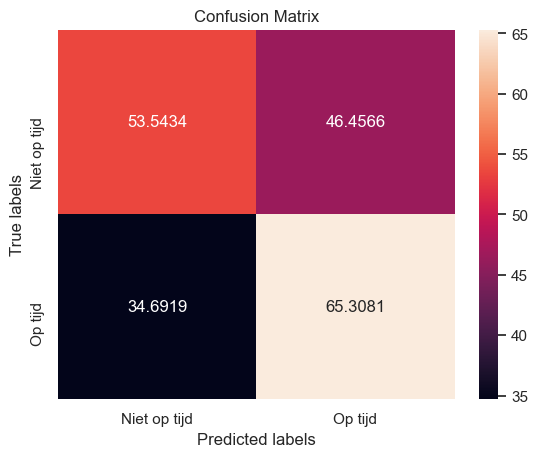

In [98]:
# Bepaalde waarde voor in de matrix
cm = confusion_matrix(y_all, y_pred.round())
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100

# Maak de plot aan
ax= plt.subplot()
sns.heatmap(cm_normalized , annot=True, fmt='g', ax=ax);

# Bepaal de waardes in de matrix
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Niet op tijd', 'Op tijd']); ax.yaxis.set_ticklabels(['Niet op tijd', 'Op tijd']);

In [73]:
# Print de scores per label
print(classification_report(y_all, y_pred.round()))

              precision    recall  f1-score   support

           0       0.61      0.54      0.57     57910
           1       0.59      0.65      0.62     58221

    accuracy                           0.59    116131
   macro avg       0.60      0.59      0.59    116131
weighted avg       0.60      0.59      0.59    116131



dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


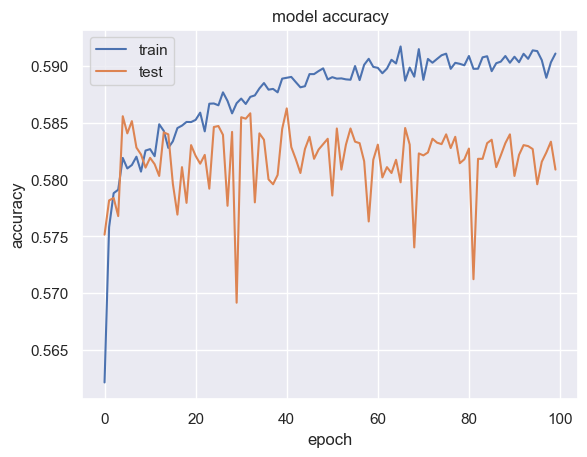

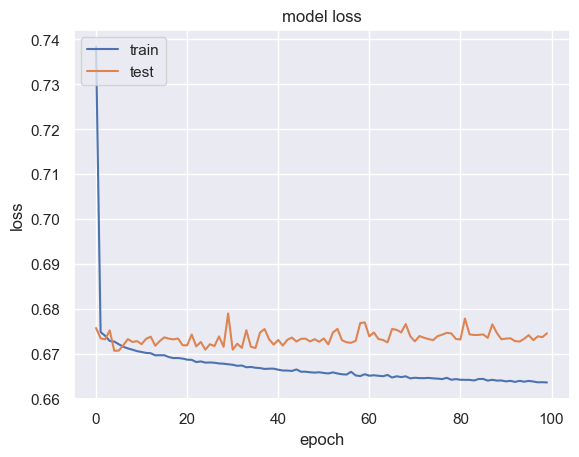

dict_keys(['loss', 'accuracy'])


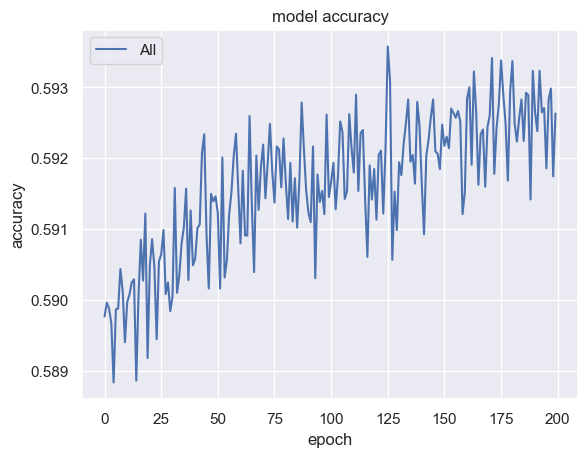

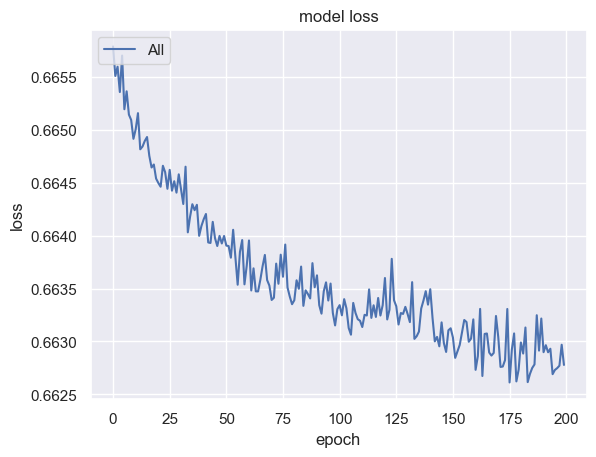

In [97]:
print(historyXY.history.keys())
# samenvattin van de nauwkeuriheid op de train en test data.
plt.plot(historyXY.history['accuracy'])
plt.plot(historyXY.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# samenvattin van de loss op de Train en test data.
plt.plot(historyXY.history['loss'])
plt.plot(historyXY.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(historyALL.history.keys())
# samenvattin van de nauwkeuriheid op de totale data.
plt.plot(historyALL.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['All'], loc='upper left')
plt.show()
# samenvattin van de loss op de totale data.
plt.plot(historyALL.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['All'], loc='upper left')
plt.show()


<font size="6">5.2 Prestaties van de regressie modellen</font>

Zoals al geconcludeerd werd in hoofdstuk 4 lijkt regressie het niet goed op deze data set. Hieronder worden de Mean Absolute Error en de Mean Absolute Error op de hele dataset, de test en de train split. Hieruit valt wel te halen dat het model het beste presteert op de train data maar ook daar nog steeds een grote afwijking laat zien.

Een reden voor de slechte prestatie van regressie op deze data kan zijn de grote spreiding en de aanwezige outliers of het grote aantal features doordat er one hot encodingis gebruikt.

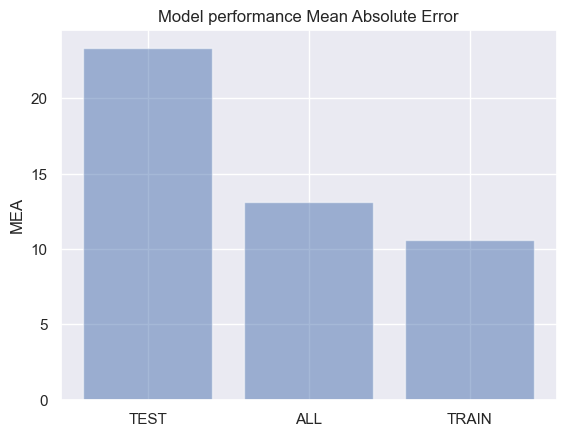

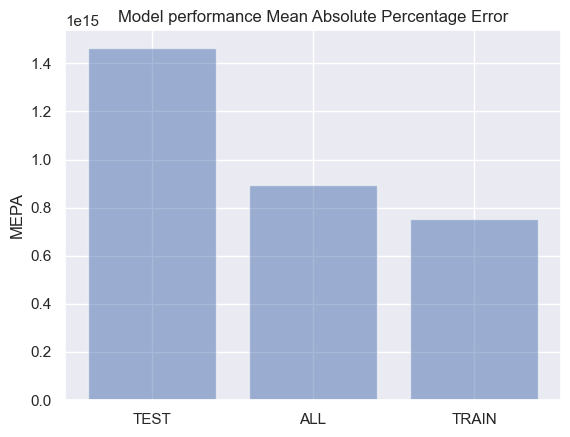

In [104]:
# Maak de plot aan voo de MEA
objects = ('TEST', 'ALL','TRAIN')
y_pos = np.arange(len(objects))
performance = [MEA_TEST,MEA_ALL,MEA_TRAIN]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MEA')
plt.title('Model performance Mean Absolute Error')

plt.show()

# Maak de plot aan voo de MAPE
objects = ('TEST', 'ALL','TRAIN')
y_pos = np.arange(len(objects))
performance = [MAPE_TEST,MAPE_ALL,MAPE_TRAIN]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MEPA')
plt.title('Model performance Mean Absolute Percentage Error')

plt.show()

<font size="6">5.3 Conclusie</font>

- Project

Binaire classificatie lijkt het beste te presteren op de factuur data zoal deze nu is opgehaald echter zijn de resultaten nog niet wat vooraf gehoopt was. Dit kan verschillende redenen hebben welke in hoofdstuk 5 al aan bod zijn gekomen.

- Ervaring

Wanneer ik terugkijk op het proces merk ik dat er nog een aantal zaken zijn waarmee ik veel moeite heb. Het gebrek aan kennis en ervaring in machine learning, python programmeren en hypertunen maken het lastig om zaken te duiden, te interpreteren en erop te acteren. Een sparringpartner hebben met meer ervaring op het gebied van machine learning kan bovenstaande zaken doen verbeteren.  